In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_log_error
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
import re
from haversine import haversine, Unit
import lightgbm as lgb
from sklearn import preprocessing
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
import xgboost
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import BayesianRidge
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error

# Data pre-processing

In [2]:
dfTrain = pd.read_csv("prepared_data/apartments_and_building_train.csv")
dfTest = pd.read_csv("prepared_data/apartments_and_building_test.csv")

In [3]:
def get_distance_center(lat1, lon1):
    dist = haversine((lat1, lon1), (55.751244, 37.618423), unit=Unit.METERS)
    return round(dist/1000, 3)

def get_distance_metro(lat, lon, coordinates):
    shortest = np.inf
    for metro_coordinate in coordinates:
        dist = haversine(metro_coordinate, (lat, lon), unit=Unit.METERS)
        if dist < shortest:
            shortest = dist
    if shortest == np.inf:
        return 100
    return round(shortest/1000, 3)

In [4]:
dfTrain["distance_center"] = dfTrain.loc[:, "latitude":"longitude"].apply(lambda x: get_distance_center(x.latitude, x.longitude), axis=1)
dfTest["distance_center"] = dfTest.loc[:, "latitude":"longitude"].apply(lambda x: get_distance_center(x.latitude, x.longitude), axis=1)

In [5]:
# get chrome driver
driver = webdriver.Chrome(ChromeDriverManager().install())
# url for page to analyze
driver.get('https://en.wikipedia.org/wiki/List_of_Moscow_Metro_stations')
# content of the page
content = driver.page_source

# find all spans with coordinates
soup = BeautifulSoup(content, features="html.parser")
spans = soup.find_all('span', class_="geo-dec")
driver.quit()

coordinates = []
numbers = re.compile(r'\d+(?:\.\d+)?')
# iterate all spans with coordinates
for span in spans:
    coord = span.get_text()
    coord = numbers.findall(coord)
    coord = [float(x) for x in coord]
    coordinates.append(tuple(coord))

dfTrain["distance_metro"] = dfTrain.loc[:, "latitude":"longitude"].apply(lambda x: get_distance_metro(x.latitude, x.longitude, coordinates), axis=1)
dfTest["distance_metro"] = dfTest.loc[:, "latitude":"longitude"].apply(lambda x: get_distance_metro(x.latitude, x.longitude, coordinates), axis=1)



====== WebDriver manager ======
Current google-chrome version is 95.0.4638
Get LATEST chromedriver version for 95.0.4638 google-chrome
Driver [C:\Users\levit\.wdm\drivers\chromedriver\win32\95.0.4638.69\chromedriver.exe] found in cache


In [6]:
def process_data(dataframe, keep_col):
    """ columns = ['building_id', 'id_x', 'id_y', 'seller', 'price', 'area_total', 'area_kitchen', 
            'area_living', 'floor', 'rooms', 'layout', 'ceiling', 'bathrooms_shared', 
            'bathrooms_private', 'windows_court', 'windows_street', 'balconies', 'loggias', 
            'condition', 'phones', 'new', 'latitude', 'longitude', 'district', 'street', 'address', 
            'constructed', 'material', 'stories', 'elevator_without', 'elevator_passenger',
            'elevator_service', 'parking', 'garbage_chute', 'heating', 'distance_center', 'distance_metro'] """

    remove_columns = ['street', 'address', 'building_id', 'id_y', 'id_x', 'price']
    
    other_remove_columns=[]
   
    for col in keep_col:
        remove_columns.remove(col)

    dataframe = dataframe.drop(remove_columns, axis=1)
    
   
    
  
            
    """
    fill_mode=['seller', 'condition', 'district','material','heating', 'parking']
    for column in dataframe.columns.values:
        
        if(column in fill_mode):
            #print("Filling "+column+" with mode")
            mode_value=dataframe[column].mode()
            dataframe[column].fillna(value=mode_value, inplace=True)
            
     fill_mean=['area_total', 'area_kitchen', 
            'area_living', 'floor', 'rooms', 'ceiling', 'bathrooms_shared', 
            'bathrooms_private', 'windows_court', 'windows_street', 'balconies', 'loggias', 'phones', 'new', 'latitude', 'longitude',
            'constructed', 'stories', 'elevator_without', 'elevator_passenger',
            'elevator_service', 'garbage_chute', 'distance_center', 'distance_metro']
    
    fill_mode=['seller', 'condition', 'district','material','heating', 'parking']

    for column in dataframe.columns.values:
        #Finding the mean of the column having NaN
        mean_value=dataframe[column].mean()
        dataframe[column].fillna(value=mean_value, inplace=True)
    
        if(column in fill_mean):
            print("Filling "+column+" with mean")
            mean_value=dataframe[column].mean()
            dataframe[column].fillna(value=mean_value, inplace=True)
            
        if(column in fill_mode):
            print("Filling "+column+" with mode")
            mode_value=dataframe[column].mode()
            dataframe[column].fillna(value=mode_value, inplace=True)
    """

    return dataframe

# LGBMRegression

<ipython-input-7-42dffb54c001>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train = X_train[(train_data["price"] < qhigh)]
C:\Users\levit\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"
C:\Users\levit\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


0
Test RMSLE: 0.159


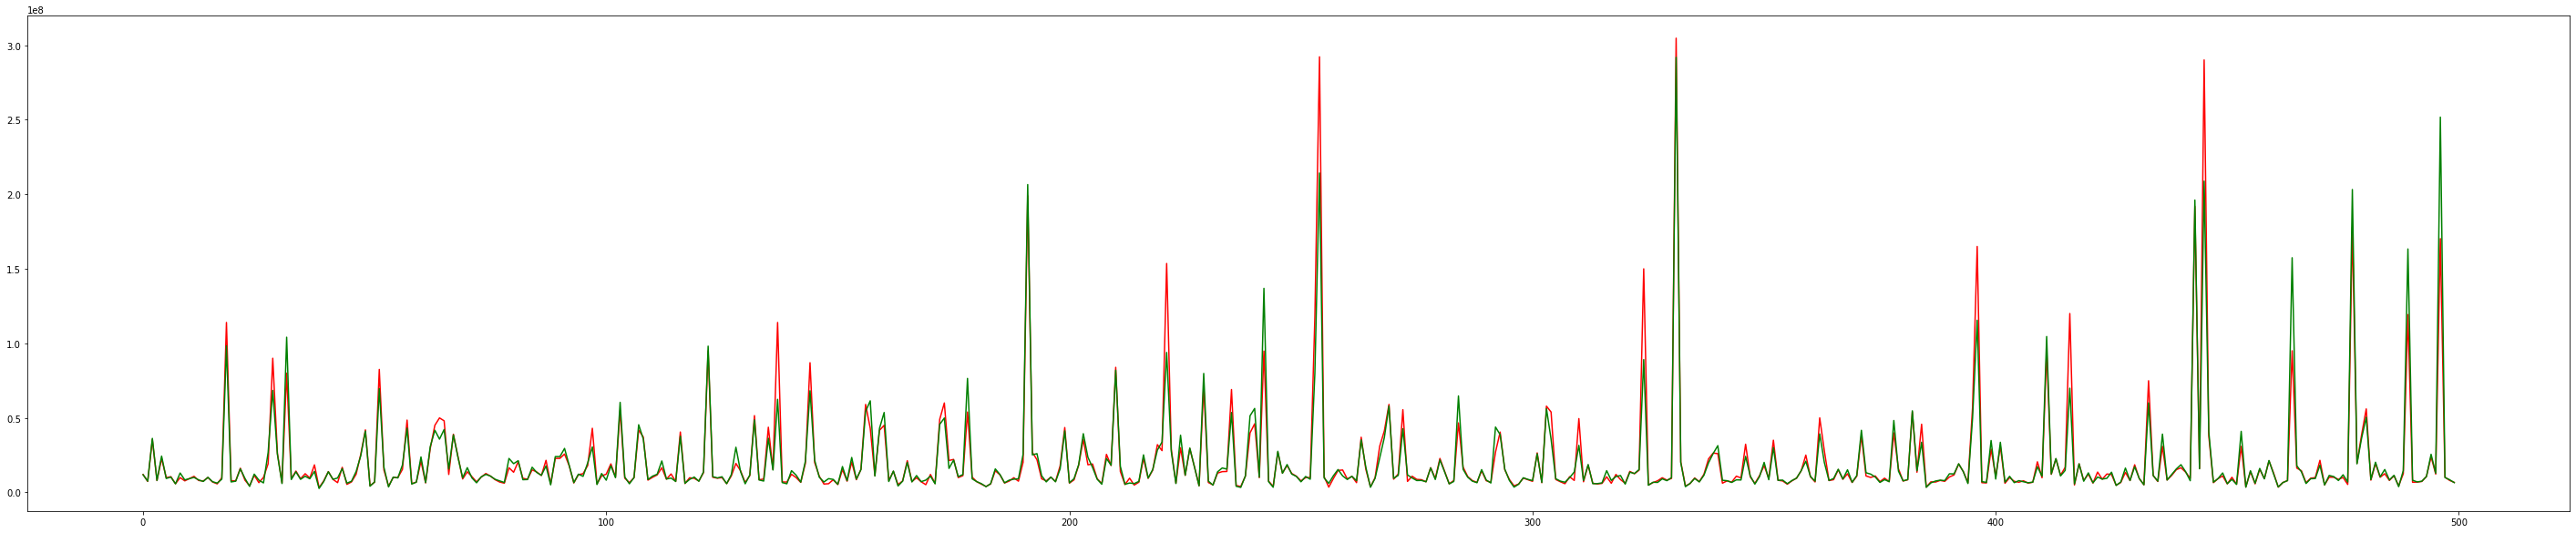

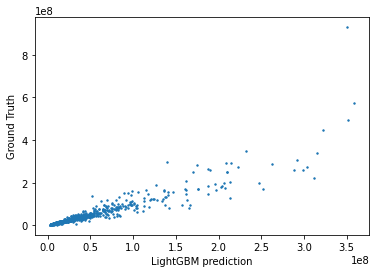

In [7]:
# normalize training data
train_data = dfTrain.copy()
train_data = process_data(train_data, keep_col=['price'])

# split training data into test and training split
X_train, X_test = train_test_split(train_data, test_size=0.10, random_state=42)

# remove apartments with very high price from training data
qhigh = X_train["price"].quantile(0.999)
X_train = X_train[(train_data["price"] < qhigh)]

# get price columns 
y_train = X_train.pop("price")
y_test = X_test.pop("price")

lgbm_regressor = lgb.LGBMRegressor(
    num_leaves=100,
    max_depth=10, 
    random_state=42,
    metric='rmsle',
    n_jobs=4, 
    n_estimators=3000,
    colsample_bytree=0.95,
    subsample=0.9,
    learning_rate=0.05
)

scaler = preprocessing.StandardScaler().fit(X_train)
imputor=IterativeImputer(
    estimator=BayesianRidge(),
    imputation_order='ascending', 
    max_iter=100,
    tol=1e-5)

X_train = imputor.fit_transform(X_train)
X_train = scaler.transform(X_train)

X_test = imputor.fit_transform(X_test)
X_test = scaler.transform(X_test)


lgbm_regressor.fit(X_train, y_train)

lgbm_prediction = lgbm_regressor.predict(X_test)

faulty_rows = []
for i in range(len(lgbm_prediction)):
    if lgbm_prediction[i] < 900000:
        lgbm_prediction[i] = 900000
        faulty_rows.append(X_test[i])

# list apartments resulting in too low price
print(len(faulty_rows))

lgbm_rmsle = round(np.sqrt(mean_squared_log_error(lgbm_prediction, y_test)), 3)
print('Test RMSLE:', lgbm_rmsle)

# red is real prices, green is predicted prices
plt.figure(figsize=(50, 10))
plt.plot(y_test.values[:500], color = 'red')
plt.plot(lgbm_prediction[:500], color = 'green')
plt.show()

# correct predictions are on the diagonal
plt.scatter(lgbm_prediction, y_test, s=2)
plt.xlabel('LightGBM prediction')
plt.ylabel('Ground Truth')
plt.show()


In [8]:
# normalize columns test data
test_data = dfTest.copy()
test_data = process_data(test_data, keep_col=['id_x', 'price'])

# separate id from test data
ids = test_data.pop("id_x")

test_data = imputor.fit_transform(test_data)
test_data = scaler.transform(test_data)


# predict
lgbm_predictions = lgbm_regressor.predict(test_data)

# replace negative predictions and low predicitons with lowest price in dataset (not ideal)
for i in range(len(lgbm_predictions)):
    if lgbm_predictions[i] < 900000:
        lgbm_predictions[i] = 900000

# create submission file
submission = pd.DataFrame(data=ids.values, columns=["id"])
submission["price_prediction"] = lgbm_predictions
submission.to_csv("lgbm_predictions.csv", index=False)

# XGBoost

In [9]:
n_estimators=[100, 500, 900, 1100, 1500]
max_depth=[2, 3, 5, 10, 15]
booster=['gbtree', 'gblinear']
learning_rate=[0.025, 0.05, 0.1, 0.15, 0.20]
min_child_weight=[1, 2, 3, 4, 5]
base_score=[0.25, 0.5, 0.75, 1]


hyperparameter_grid={
    'n_estimators':n_estimators,
    'max_depth':max_depth,
    'booster':booster,
    'learning_rate':learning_rate,
    'min_child_weight':min_child_weight,
    'base_score': base_score
    
}

<ipython-input-10-26fce178ce5e>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train = X_train[(train_data["price"] < qhigh)]
C:\Users\levit\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"
C:\Users\levit\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


0
Test RMSLE: 0.152


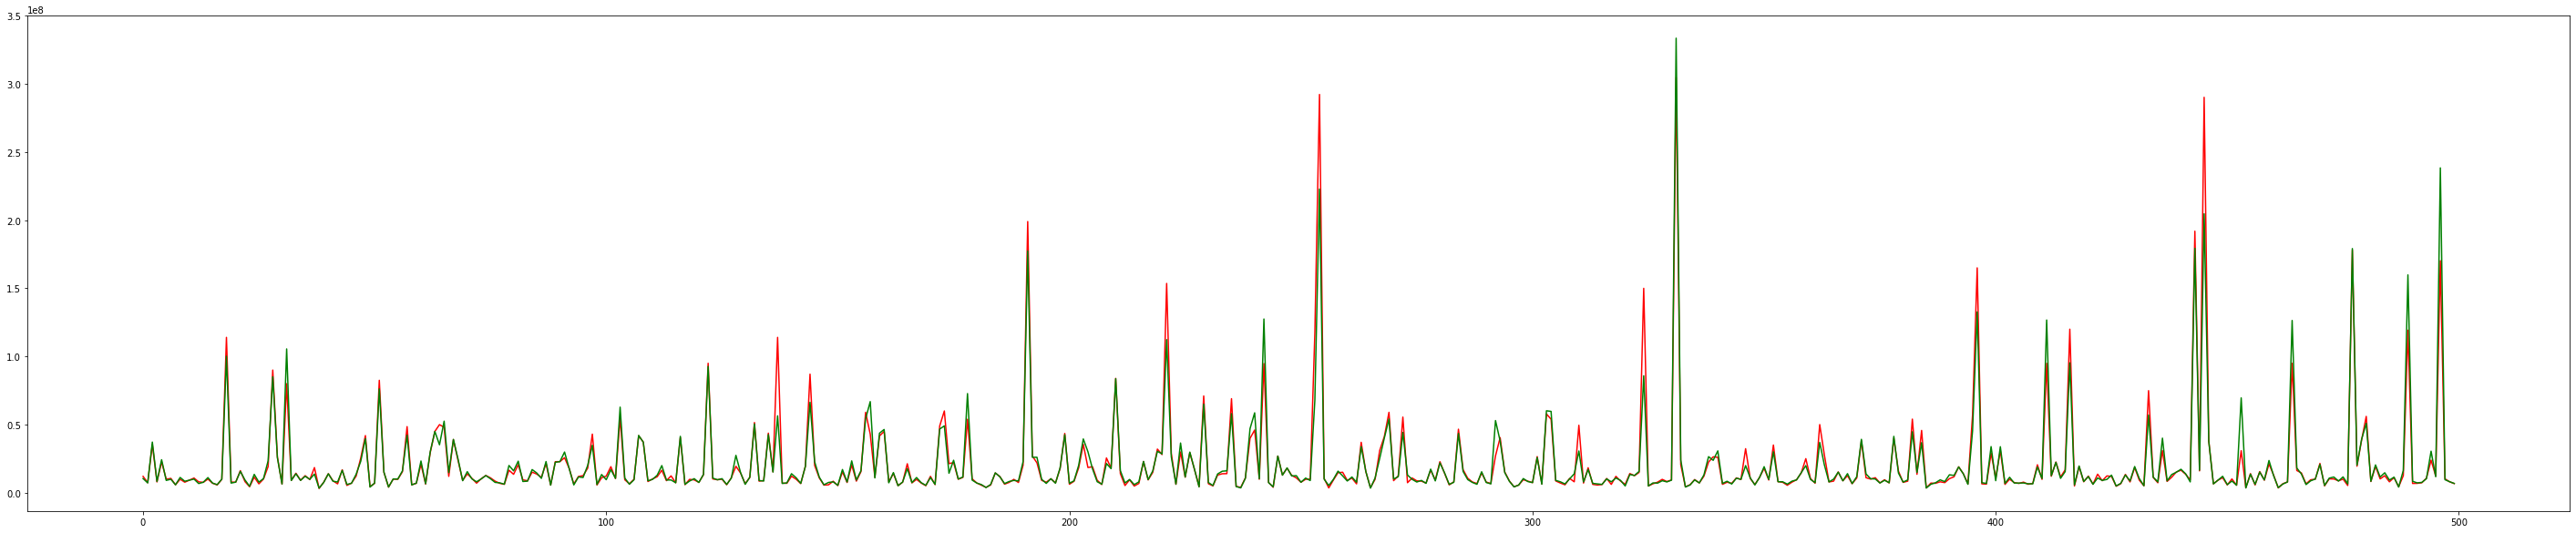

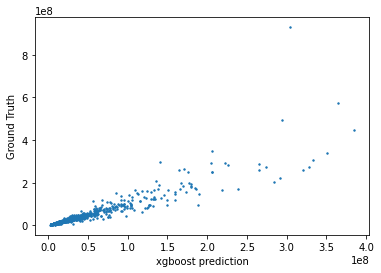

In [10]:
train_data = dfTrain.copy()
train_data = process_data(train_data, keep_col=['price'])

# split training data into test and training split
X_train, X_test = train_test_split(train_data, test_size=0.10, random_state=42)

# remove apartments with very high price from training data
qhigh = X_train["price"].quantile(0.999)
X_train = X_train[(train_data["price"] < qhigh)]

# get price columns 
y_train = X_train.pop("price")
y_test = X_test.pop("price")


scaler = preprocessing.StandardScaler().fit(X_train)

imputor=IterativeImputer(
    estimator=BayesianRidge(),
    imputation_order='ascending', 
    max_iter=100,
    tol=1e-5)

X_train = imputor.fit_transform(X_train)
X_train = scaler.transform(X_train)

X_test = imputor.fit_transform(X_test)
X_test = scaler.transform(X_test)


"""
classifier=xgboost.XGBRegressor()

random_cv=RandomizedSearchCV(estimator=classifier, 
                             param_distributions=hyperparameter_grid, 
                             cv=5, 
                             scoring='neg_mean_absolute_error',
                             n_jobs=4,
                             verbose=5,
                             return_train_score=True,
                             random_state=42
                            )
random_cv.fit(X_train, y_train)
random_cv.best_estimator_
"""
xgboost_regressor=xgboost.XGBRegressor(base_score=0.25, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.15, max_delta_step=0,
             max_depth=10, min_child_weight=4,
             monotone_constraints='()', n_estimators=500, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)


xgboost_regressor.fit(X_train, y_train)

xgboost_prediction = xgboost_regressor.predict(X_test)


faulty_rows = []
for i in range(len(xgboost_prediction)):
    if xgboost_prediction[i] < 900000:
        xgboost_prediction[i] = 900000
        faulty_rows.append(X_test[i])

# list apartments resulting in too low price
print(len(faulty_rows))

xgboost_rmsle = round(np.sqrt(mean_squared_log_error(xgboost_prediction, y_test)), 3)
print('Test RMSLE:', xgboost_rmsle)

# red is real prices, green is predicted prices
plt.figure(figsize=(50, 10))
plt.plot(y_test.values[:500], color = 'red')
plt.plot(xgboost_prediction[:500], color = 'green')
plt.show()

# correct predictions are on the diagonal
plt.scatter(xgboost_prediction, y_test, s=2)
plt.xlabel('xgboost prediction')
plt.ylabel('Ground Truth')
plt.show()


In [11]:
# normalize columns test data
test_data = dfTest.copy()
test_data = process_data(test_data, keep_col=['id_x', 'price'])

# separate id from test data
ids = test_data.pop("id_x")

test_data = imputor.fit_transform(test_data)
test_data = scaler.transform(test_data)


# predict
xgboost_predictions = xgboost_regressor.predict(test_data)

# replace negative predictions and low predicitons with lowest price in dataset (not ideal)
for i in range(len(xgboost_predictions)):
    if xgboost_predictions[i] < 900000:
        xgboost_predictions[i] = 900000

# create submission file
submission = pd.DataFrame(data=ids.values, columns=["id"])
submission["price_prediction"] = xgboost_predictions
submission.to_csv("xgboost_predictions.csv", index=False)

 # Catboost

<ipython-input-235-a1178e60417d>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train = X_train[(train_data["price"] < qhigh)]
C:\Users\levit\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"
C:\Users\levit\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


0
Test RMSLE: 0.17


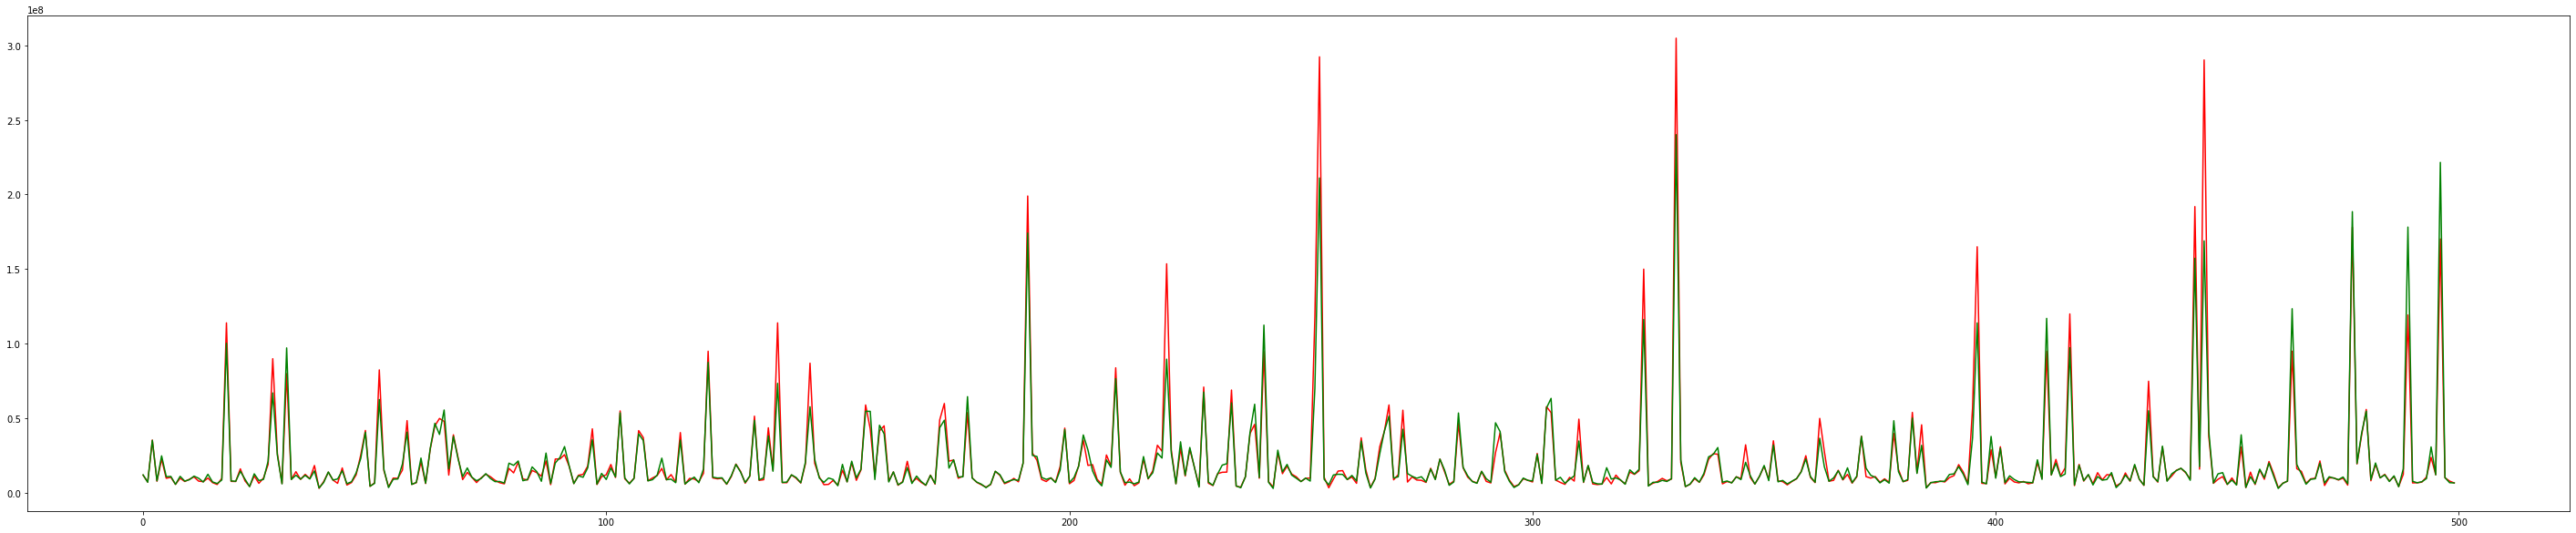

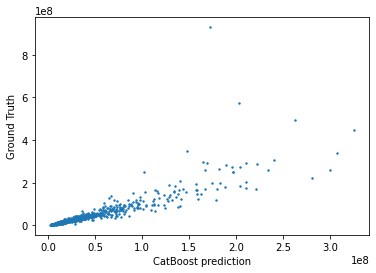

In [235]:
# normalize training data
train_data = dfTrain.copy()
train_data = process_data(train_data, keep_col=['price'])

# split training data into test and training split
X_train, X_test = train_test_split(train_data, test_size=0.10, random_state=42)

# remove apartments with very high price from training data
qhigh = X_train["price"].quantile(0.999)
X_train = X_train[(train_data["price"] < qhigh)]

# get price columns 
y_train = X_train.pop("price")
y_test = X_test.pop("price")

scaler = preprocessing.StandardScaler().fit(X_train)
imputor=IterativeImputer(
    estimator=BayesianRidge(),
    imputation_order='ascending', 
    max_iter=100,
    tol=1e-5
)

X_train = imputor.fit_transform(X_train)
X_train = scaler.transform(X_train)

X_test = imputor.fit_transform(X_test)
X_test = scaler.transform(X_test)



catboost_regressor = CatBoostRegressor(
    n_estimators=2000,
    learning_rate=0.1,
    thread_count=-1,
    depth=12,
    silent=True,
    random_state=42,
    bagging_temperature=0.2
#     od_type="Iter"
)

#cat_features=['seller', 'condition', 'district','material','heating', 'parking']

catboost_regressor.fit(X_train, y_train)

cat_boost_prediction = catboost_regressor.predict(X_test)

faulty_rows = []
for i in range(len(cat_boost_prediction)):
    if cat_boost_prediction[i] < 900000:
        cat_boost_prediction[i] = 900000
        faulty_rows.append(X_test[i])

# list apartments resulting in too low price
print(len(faulty_rows))

cat_boost_rmsle = round(np.sqrt(mean_squared_log_error(cat_boost_prediction, y_test)), 3)
print('Test RMSLE:', cat_boost_rmsle)

# red is real prices, green is predicted prices
plt.figure(figsize=(50, 10))
plt.plot(y_test.values[:500], color = 'red')
plt.plot(cat_boost_prediction[:500], color = 'green')
plt.show()

# correct predictions are on the diagonal
plt.scatter(cat_boost_prediction, y_test, s=2)
plt.xlabel('CatBoost prediction')
plt.ylabel('Ground Truth')
plt.show()

In [234]:
# normalize columns test data
test_data = dfTest.copy()
test_data = process_data(test_data, keep_col=['id_x', 'price'])

# separate id from test data
ids = test_data.pop("id_x")

test_data = imputor.fit_transform(test_data)
test_data = scaler.transform(test_data)

# predict
catboost_predictions = catboost_regressor.predict(test_data)

# replace negative predictions and low predicitons with lowest price in dataset (not ideal)
for i in range(len(catboost_predictions)):
    if catboost_predictions[i] < 900000:
        catboost_predictions[i] = 900000

# create submission file
submission = pd.DataFrame(data=ids.values, columns=["id"])
submission["price_prediction"] = xgboost_predictions
submission.to_csv("catboost_predictions.csv", index=False)

# Stacking

In [21]:
acc = pd.DataFrame(
    {'LightGBM':     lgbm_rmsle,
     'XGBoost':      xgboost_rmsle,
     'CatBoost':     cat_boost_rmsle},
    index=[0]
)
acc = acc.T
acc.columns = ['MSE']
acc

,MSE
LightGBM,0.159
XGBoost,0.152
CatBoost,0.165


# Simple averaging

In [25]:
avg_predictions = np.average(
    [lgbm_predictions,
     xgboost_predictions,
     catboost_predictions
    ],
    weights = 1 / acc['MSE'] ** 4,
    axis=0
)


#print('Test MSE:', round(mean_squared_error(avg_predictions, test_data_y), 2))

In [26]:
#plt.scatter(avg_predictions, y_test)
#plt.xlabel('Average Prediction')
#plt.ylabel('Ground Truth')

In [27]:
# create submission file
submission = pd.DataFrame(data=ids.values, columns=["id"])
submission["price_prediction"] =  avg_predictions
submission.to_csv("average_predictions.csv", index=False)

# True Stacking

### First Step

In [222]:
train_data = dfTrain.copy()
train_data = process_data(train_data, keep_col=['price'])

# split training data into test and training split
X_train, X_test = train_test_split(train_data, test_size=0.10, random_state=42)

# remove apartments with very high price from training data
qhigh = X_train["price"].quantile(0.999)
X_train = X_train[(train_data["price"] < qhigh)]

# get price columns 
y_train = X_train.pop("price")
y_test = X_test.pop("price")

test_data = dfTest.copy()
test_data = process_data(test_data, keep_col=['id_x', 'price'])


scaler = preprocessing.StandardScaler().fit(X_train)
imputor=IterativeImputer(
    estimator=BayesianRidge(),
    imputation_order='ascending', 
    max_iter=100,
    tol=1e-5)


X_train = imputor.fit_transform(X_train)
X_train = scaler.transform(X_train)
X_train = pd.DataFrame(X_train)

X_test = imputor.fit_transform(X_test)
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test)



<ipython-input-222-ed88c09e46e1>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train = X_train[(train_data["price"] < qhigh)]
C:\Users\levit\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"
C:\Users\levit\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


In [223]:
# normalize columns test data
test_data = dfTest.copy()
test_data = process_data(test_data, keep_col=['id_x', 'price'])

# separate id from test data
ids = test_data.pop("id_x")

test_data = imputor.fit_transform(test_data)
test_data = scaler.transform(test_data)
test_data = pd.DataFrame(test_data)


In [224]:
ntrain = X_train.shape[0]
ntest = test_data.shape[0]
SEED = 42 # for reproducibility
NFOLDS = 5 # set number of folds for out-of-fold prediction
kf = KFold(
    n_splits=NFOLDS,
    shuffle=True,
    random_state=SEED
) # K-Folds cross-validator

def get_oof(clf, x_train, y_train, x_test):
    """
    Popular function on Kaggle.
    
    Trains a classifier on 4/5 of the training data and
    predicts the rest (1/5). This procedure is repeated for all 5 folds,
    thus we have predictions for all training set. This prediction is one
    column of meta-data, later on used as a feature column by a meta-algorithm.
    We predict the test part and average predictions across all 5 models.
    
    Keyword arguments:
    clf -- classifier
    x_train -- 4/5 of training data
    y_train -- corresponding labels
    x_test -- all test data
    
    """
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.fit(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [225]:
lgbm_regressor = lgb.LGBMRegressor(
    num_leaves=100,
    max_depth=10, 
    random_state=42,
    metric='rmsle',
    n_jobs=4, 
    n_estimators=3000,
    colsample_bytree=0.95,
    subsample=0.9,
    learning_rate=0.05
)

xgboost_regressor=xgboost.XGBRegressor(base_score=0.25, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.15, max_delta_step=0,
             max_depth=10, min_child_weight=4,
             monotone_constraints='()', n_estimators=500, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)


catboost_regressor = CatBoostRegressor(
    n_estimators=1000,
    learning_rate=0.1,
    thread_count=-1,
    depth=10,
    silent=True,
    random_state=42,
    bagging_temperature=0.2
#     od_type="Iter"
)

In [226]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.ravel()

dt_oof_train, dt_oof_test = get_oof(lgbm_regressor, X_train, y_train, test_data)
print('All preictions for train set:', len(dt_oof_train))
print('All preictions for test set:', len(dt_oof_test))

All preictions for train set: 20935
All preictions for test set: 9937


In [228]:
lgbm_oof_train, lgbm_oof_test = get_oof(lgbm_regressor, X_train, y_train, test_data)
xgb_oof_train, xgb_oof_test = get_oof(xgboost_regressor, X_train, y_train, test_data)
cat_oof_train, cat_oof_test = get_oof(catboost_regressor, X_train, y_train, test_data)

### Second Step

In [229]:
x_train = np.concatenate((
    lgbm_oof_train,
    xgb_oof_train,
    cat_oof_train
), axis=1)

x_test = np.concatenate((
    lgbm_oof_test,
    xgb_oof_test,
    cat_oof_test
), axis=1)

In [230]:
META_MODEL = lgb.LGBMRegressor(
    num_leaves=5,
    max_depth=7, 
    random_state=SEED, 
    silent=True, 
    metric='mse',
    n_jobs=4, 
    n_estimators=200,
    colsample_bytree=1,
    subsample=0.9,
    learning_rate=0.05
)

META_MODEL.fit(x_train, y_train)

LGBMRegressor(colsample_bytree=1, learning_rate=0.05, max_depth=7, metric='mse',
              n_estimators=200, n_jobs=4, num_leaves=5, random_state=42,
              subsample=0.9)

In [231]:
final_predictions = META_MODEL.predict(x_test)

In [232]:
submission = pd.DataFrame(data=ids.values, columns=["id"])
submission["price_prediction"] =  final_predictions
submission.to_csv("final_predictions.csv", index=False)

In [203]:
cat_mse = round(mean_squared_log_error(final_predictions, y_test), 2)
print('Test MSE:', cat_mse)

Test MSE: 0.02


Text(0, 0.5, 'Ground Truth')

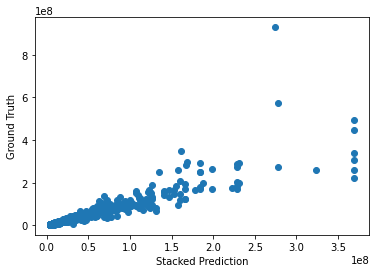

In [208]:
plt.scatter(final_predictions, y_test)
plt.xlabel('Stacked Prediction')
plt.ylabel('Ground Truth')

In [ ]:
submission = pd.DataFrame(data=ids.values, columns=["id"])
submission["price_prediction"] =  final_predictions
submission.to_csv("final_predictions.csv", index=False)